# Prelude

In [2]:
# Zip File Download and Extraction
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# Census Data Extraction
from census import Census
import pandas as pd

# GeoTif file extraction
import geopandas as gpd
from shapely import Polygon, Point
import rioxarray
# from rioxarray.merge import merge_arrays


C:\Users\Kabir\AppData\Local\Temp\ipykernel_17880\932919800.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [38]:
# File locations for windows file system.

transit_routes_url = 'https://seshat.datasd.org/gis_transit_routes/transit_routes_datasd.zip'
transit_stops_url = 'https://seshat.datasd.org/gis_transit_stops/transit_stops_datasd.zip'
california_tracts_url = 'https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_06_tract.zip'
us_counties_url = 'https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip'
HRPD_url = 'https://data.humdata.org/dataset/eec3a01f-5237-4896-8059-a6be193ca964/resource/58b480a3-afbd-4d1e-bd9f-5ef480bffb61/download/population_usa28_-120_2019-07-01.tif.zip'

transit_routes_file = ".\\Data\\transit_routes\\"
transit_stops_file = ".\\Data\\transit_stops\\"
california_tracts_file = ".\\Data\\california_tracts\\"
us_counties_file = ".\\Data\\us_counties\\"
HRPD_file = '.\\Data\\HRPD\\'


california_tracts_file_name = 'tl_2021_06_tract.shp'
us_counties_file_name = 'tl_2021_us_county.shp'
HRPD_file_name = 'population_usa28_-120_2019-07-01.tif'
HRPD_sd_shp_file_name = 'HRPD_sd.shp'

commute_file_name = '.\\Data\\commute_time.csv'

In [ ]:
# Only need to run Data Collection and Transformation once.
# after that run this chunk to load the data, so you dont 
# have to redownload and reprocess the data.

# This code chunck will be Placed lower in the final verison.

commute_df = pd.read_csv(commute_file_name)

HRPD_sd_df = gpd.read_file(HRPD_file + HRPD_sd_shp_file_name)

tract_df = gpd\
    .read_file(california_tracts_file + california_tracts_file_name)\
    .to_crs("EPSG:4326")
    
tract_df = tract_df.loc[tract_df['COUNTYFP']== '073',]

# Data Collection and Transformation

## Download & Unzip shape and raster files.

In [ ]:
def download_unzip(file_url,file_location):
    with urlopen(file_url) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(file_location)

download_unzip(transit_routes_url,transit_routes_file)
download_unzip(transit_stops_url,transit_stops_file)
download_unzip(california_tracts_url,california_tracts_file)
download_unzip(us_counties_url,us_counties_file)
download_unzip(HRPD_url,HRPD_file)

### Install Required Python Packages.

In [ ]:
!pip install requirements.txt

## Create Census Data Table

In [43]:
#You can request an API key from https://api.census.gov/data/key_signup.html
API_KEY = '9e94761d2b2fb214be8b88bdaeccc47b8edded35'

c = Census(API_KEY,
           year=2021)

#See https://api.census.gov/data/2021/acs/acs5/groups/B08303.html for available fields
commute_census = c.acs5.state_county_tract(
    

    state_fips = "06",      # California
    county_fips = "073",    # San Diego
    tract = "*",            # All tracts
    fields =                # All Estimate Fields in Coummute survery table.
        ['B08303_0'+str(i).zfill(2)+'E' for i in range(1,14)],
)

In [ ]:
commute_df = pd.DataFrame(commute_census)

### Rename Columns to appropriate title

In [45]:
name_list = ['Total'
             , 'Less than 5 mins'
             , '5 to 10 Mins'
             , '10 to 15 Mins'
             , '15 to 20 Mins'
             , '20 to 25 Mins'
             , '25 to 30 Mins'
             , '30 to 35 Mins'
             , '35 to 40 Mins'
             , '40 to 45 Mins'
             , '45 to 60 Mins'
             , '60 to 90 Mins'
             , 'More than 90 Mins']
key_list = ['B08303_0'+str(i).zfill(2)+'E' for i in range(1,14)]
column_rename = {key_list[i]: name_list[i] for i in range(0,13)}

commute_df = commute_df.rename(columns=column_rename)

commute_df

,Total,Less than 5 mins,5 to 10 Mins,10 to 15 Mins,15 to 20 Mins,20 to 25 Mins,25 to 30 Mins,30 to 35 Mins,35 to 40 Mins,40 to 45 Mins,45 to 60 Mins,60 to 90 Mins,More than 90 Mins,state,county,tract
0,982.0,7.0,68.0,152.0,261.0,152.0,75.0,158.0,0.0,44.0,60.0,0.0,5.0,06,073,000100
1,935.0,21.0,166.0,161.0,184.0,122.0,10.0,117.0,19.0,52.0,74.0,0.0,9.0,06,073,000201
2,2184.0,23.0,118.0,408.0,553.0,444.0,98.0,261.0,0.0,21.0,136.0,88.0,34.0,06,073,000202
3,1376.0,29.0,23.0,352.0,245.0,224.0,69.0,150.0,49.0,12.0,131.0,51.0,41.0,06,073,000301
4,1860.0,36.0,397.0,258.0,337.0,226.0,55.0,342.0,57.0,21.0,94.0,9.0,28.0,06,073,000302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,2030.0,40.0,210.0,372.0,304.0,273.0,146.0,307.0,64.0,65.0,130.0,92.0,27.0,06,073,021900
733,2040.0,0.0,214.0,181.0,578.0,257.0,131.0,262.0,23.0,60.0,35.0,90.0,209.0,06,073,022000
734,708.0,0.0,161.0,137.0,52.0,48.0,10.0,89.0,10.0,20.0,98.0,77.0,6.0,06,073,022101
735,1950.0,0.0,163.0,313.0,446.0,188.0,47.0,231.0,127.0,16.0,243.0,100.0,76.0,06,073,022102


### Remove trivial columns and rows.

In [46]:
commute_df = commute_df.drop(columns=['state','county'], index=[736])

### Add Mean Time Column

In [47]:
commute_mean_time = [0 for x in range(736)]
for i in range(1,10):
    commute_mean_time = commute_mean_time + \
        commute_df[name_list[i]]*(2.5+(i-1)*5)

commute_mean_time = commute_mean_time +  commute_df[name_list[10]]*52.75
commute_mean_time = commute_mean_time +  commute_df[name_list[11]]*75
commute_mean_time = commute_mean_time/commute_df['Total']

# Ignoring 90 mins for now.
# commute_mean_time.mean()

commute_df['Mean Time'] = commute_mean_time

### Save Dataframe to CSV file

In [48]:
commute_df.to_csv(commute_file_name,index=False)
commute_df

,Total,Less than 5 mins,5 to 10 Mins,10 to 15 Mins,15 to 20 Mins,20 to 25 Mins,25 to 30 Mins,30 to 35 Mins,35 to 40 Mins,40 to 45 Mins,45 to 60 Mins,60 to 90 Mins,More than 90 Mins,tract,Mean Time
0,982.0,7.0,68.0,152.0,261.0,152.0,75.0,158.0,0.0,44.0,60.0,0.0,5.0,000100,23.062627
1,935.0,21.0,166.0,161.0,184.0,122.0,10.0,117.0,19.0,52.0,74.0,0.0,9.0,000201,21.581283
2,2184.0,23.0,118.0,408.0,553.0,444.0,98.0,261.0,0.0,21.0,136.0,88.0,34.0,000202,23.605311
3,1376.0,29.0,23.0,352.0,245.0,224.0,69.0,150.0,49.0,12.0,131.0,51.0,41.0,000301,24.584121
4,1860.0,36.0,397.0,258.0,337.0,226.0,55.0,342.0,57.0,21.0,94.0,9.0,28.0,000302,20.734409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,658.0,3.0,48.0,71.0,202.0,150.0,35.0,29.0,43.0,0.0,19.0,49.0,9.0,021800,24.862842
732,2030.0,40.0,210.0,372.0,304.0,273.0,146.0,307.0,64.0,65.0,130.0,92.0,27.0,021900,24.975369
733,2040.0,0.0,214.0,181.0,578.0,257.0,131.0,262.0,23.0,60.0,35.0,90.0,209.0,022000,21.515319
734,708.0,0.0,161.0,137.0,52.0,48.0,10.0,89.0,10.0,20.0,98.0,77.0,6.0,022101,28.597458


## Convert HRPD Raster Data to Shapefile

In [34]:
county_df = gpd.read_file(us_counties_file + us_counties_file_name).to_crs("EPSG:4326")
county_df = county_df.loc[county_df['NAME']== 'San Diego',]

san_deigo_polygon = county_df.loc[539,'geometry']

In [35]:
# Takes some Time (35sec on desktop)
HRPD_tif = rioxarray.open_rasterio(HRPD_file + HRPD_file_name)
HRPD_tif = HRPD_tif.rio.reproject("EPSG:4326")
HRPD_sd_tif = HRPD_tif.rio.clip([san_deigo_polygon])

In [36]:
HRPD_sd_df = HRPD_sd_tif[0].to_dataframe('Population').dropna()

# Takes some Time (10sec on desktop)
HRPD_sd_df['geometry'] = [Point(index[1],index[0]) for index,row in HRPD_sd_df.iterrows()]

HRPD_sd_df = gpd.GeoDataFrame(HRPD_sd_df['Population'],
                              geometry = HRPD_sd_df['geometry'])\
                                .reset_index(drop=True)

In [41]:
# Takes some Time (25sec on desktop)
HRPD_sd_df.to_file(HRPD_file + HRPD_sd_shp_file_name, 
                   index=False,
                   crs='EPSG:4326')
HRPD_sd_df

,Population,geometry
0,0.134667,POINT (-117.37083 33.49083)
1,0.908454,POINT (-117.40111 33.48444)
2,0.908454,POINT (-117.40111 33.48389)
3,0.908454,POINT (-117.40000 33.48361)
4,0.908454,POINT (-117.37444 33.48111)
...,...,...
797661,0.074160,POINT (-117.11417 32.53556)
797662,0.074160,POINT (-117.11389 32.53556)
797663,0.074160,POINT (-117.11889 32.53528)
797664,0.074160,POINT (-117.11694 32.53528)


# Regression Models

# Scratch Code for Testing

In [ ]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt

tract_df = gpd.read_file(california_tracts_file+'tl_2021_06_tract.shp').to_crs("EPSG:4326")
tract_df = tract_df.loc[tract_df['COUNTYFP']== '073',]

fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(16,12))
tract_df.boundary.plot(ax=ax,linewidth=0.2)
HRPD_sd_df.plot(column='Population',
                           ax=ax,
                           markersize=0.01,
                           cmap='YlGnBu',
                           legend=True,
                           norm=colors.LogNorm(0.0029,520)
                           )
plt.title("High resolution population Density - San Diego",
          fontsize=25)

In [106]:
cliped

,Population,geometry
569630,2.548391,POINT (-117.23611 32.78028)
569631,2.548391,POINT (-117.23583 32.78028)
567597,3.426170,POINT (-117.23528 32.78139)
553323,11.420566,POINT (-117.23361 32.78972)
567598,3.426170,POINT (-117.23500 32.78139)
...,...,...
544544,9.344099,POINT (-117.23528 32.79417)
544543,8.928806,POINT (-117.23556 32.79417)
544541,3.460777,POINT (-117.23611 32.79417)
543930,9.344099,POINT (-117.23528 32.79472)


In [110]:
x = 0
y = 0
pop_total = 0
for index,row in cliped.iterrows():
   x += row['geometry'].x*row['Population']
   y += row['geometry'].y*row['Population']
   pop_total += row['Population']
centre = Point(x/pop_total ,y/pop_total )

In [113]:
gpd.GeoSeries(centre)

0    POINT (-117.23514 32.79093)
dtype: geometry

Text(0.5, 1.0, 'High resolution population Density - tract 007702')

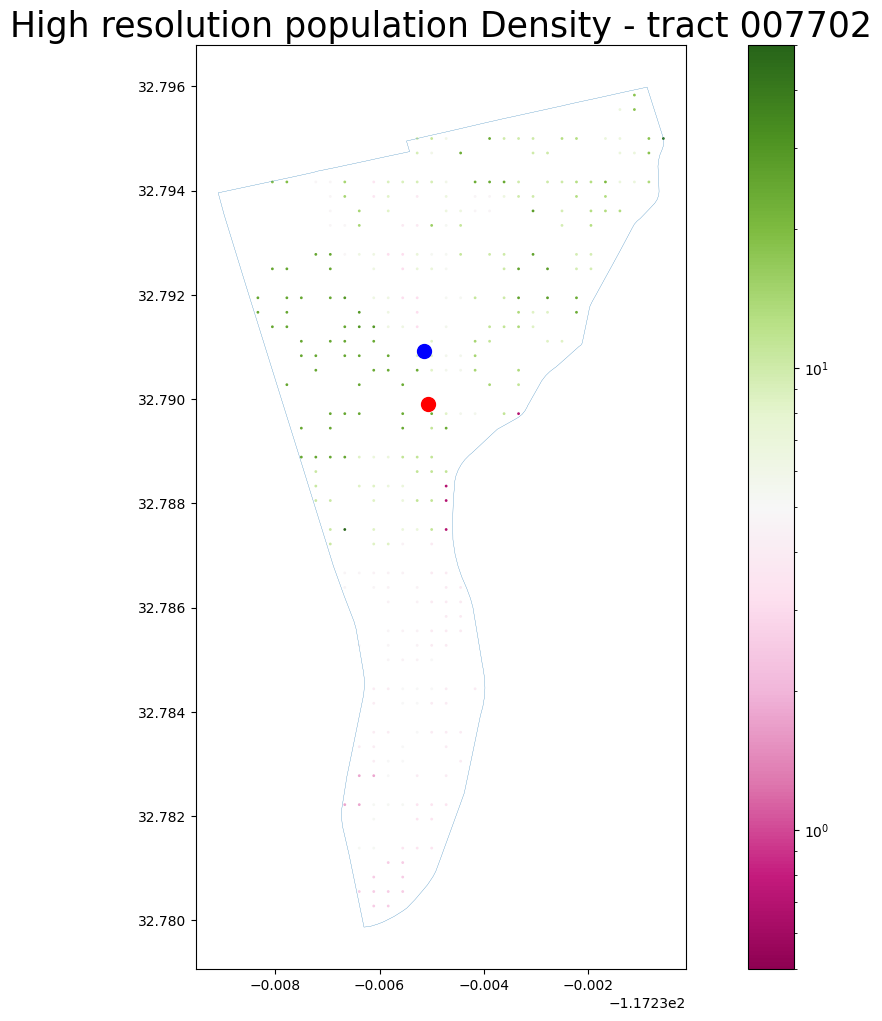

In [111]:
tract_polygon = tract_df.loc[1627,'geometry']
cliped = HRPD_sd_df.clip(tract_polygon)

fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(16,12))
gpd.GeoSeries(tract_polygon).boundary.plot(ax=ax,linewidth=0.2)
cliped.plot(column='Population',
                           ax=ax,
                           markersize=1,
                           cmap='PiYG',
                           legend=True,
                           norm=colors.LogNorm(0.5,50)
                           )
gpd.GeoSeries(tract_polygon.centroid).plot(ax=ax,
                           markersize=100,color='red')
gpd.GeoSeries(centre).plot(ax=ax,
                           markersize=100,color='blue')
plt.title("High resolution population Density - tract 007702",
          fontsize=25)